In [1]:
from torchvision.models.feature_extraction import create_feature_extractor
from transformers import DetrImageProcessor, DetrForObjectDetection, DetrConfig
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
from pre_training_backbone import PreTrainingBackboneForImageClassification
from transformers import AutoConfig, AutoModelForObjectDetection, AutoImageProcessor
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights
from torch import nn

/home/hicham/miniconda3/envs/phd/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

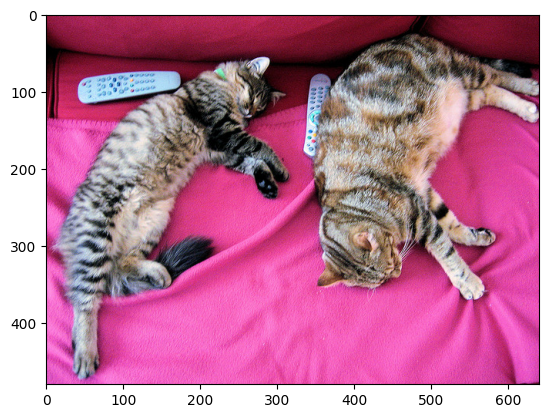

In [3]:
plt.imshow(image)

In [4]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
config = DetrConfig.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
# model = DetrForObjectDetection(config)

/home/hicham/miniconda3/envs/phd/lib/python3.12/site-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/hicham/miniconda3/envs/phd/lib/python3.12/site-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/hicham/miniconda3/envs/phd/lib/python3.12/site-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta para

In [5]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [6]:
def normalize_map(x):
    """Normalize a 2D map to [0,1]."""
    x = x - x.min()
    x = x / (x.max() + 1e-5)
    return x

In [7]:
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])

In [8]:
outputs.encoder_last_hidden_state[0].shape

torch.Size([850, 256])

In [9]:
features_map = model.model.backbone.conv_encoder.model(inputs['pixel_values'])[0].detach().numpy()[0]
features_map.shape

(256, 200, 267)

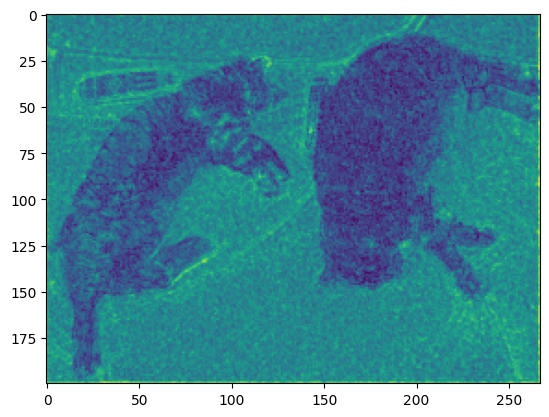

In [10]:
plt.imshow(normalize_map(np.mean(features_map, axis=0)), cmap="viridis")

In [11]:
maps = [normalize_map(features_map[i]) for i in range(features_map.shape[0])]
mean_map = np.stack(maps).mean(0)
mean_map.shape

(200, 267)

In [12]:
pretrain_backbone_config = AutoConfig.from_pretrained("checkpoints/detr-resnet50-15epochs")
object_detection_model = AutoModelForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    config=config,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
pretrain_backbone_model = PreTrainingBackboneForImageClassification.from_pretrained("checkpoints/detr-resnet50-15epochs", config=config, model=object_detection_model)

In [14]:
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/detr-resnet-50"
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [15]:
inputs['pixel_values'].shape

torch.Size([1, 3, 800, 1066])

In [16]:
inputs = image_processor(images=image, return_tensors="pt")
outputs = pretrain_backbone_model.backbone(inputs['pixel_values'])

In [17]:
features_map = outputs[0].squeeze().detach().numpy()
features_map.shape

(256, 200, 267)

In [18]:
normalize_map(np.mean(features_map, axis=0)).shape

(200, 267)

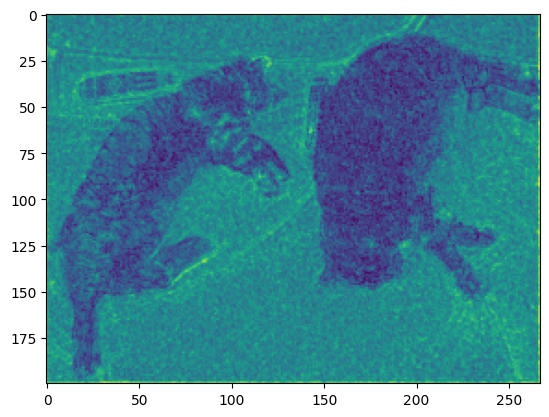

In [19]:
plt.imshow(normalize_map(np.mean(features_map, axis=0)), cmap="viridis")

In [20]:
pretrain_backbone_model.backbone.layer2[2].conv1.weight

Parameter containing:
tensor([[[[ 0.0037]],

         [[-0.0023]],

         [[-0.0280]],

         ...,

         [[ 0.0181]],

         [[ 0.0095]],

         [[ 0.0267]]],


        [[[ 0.0012]],

         [[-0.0360]],

         [[-0.0196]],

         ...,

         [[ 0.0136]],

         [[ 0.0142]],

         [[-0.0216]]],


        [[[-0.0061]],

         [[-0.0258]],

         [[ 0.0138]],

         ...,

         [[ 0.0228]],

         [[-0.0507]],

         [[ 0.0019]]],


        ...,


        [[[ 0.0085]],

         [[ 0.0079]],

         [[-0.0073]],

         ...,

         [[ 0.0329]],

         [[ 0.0145]],

         [[ 0.0740]]],


        [[[ 0.0109]],

         [[ 0.0064]],

         [[-0.0017]],

         ...,

         [[ 0.0577]],

         [[ 0.0368]],

         [[-0.0109]]],


        [[[ 0.0259]],

         [[-0.0029]],

         [[ 0.0647]],

         ...,

         [[-0.0078]],

         [[ 0.0187]],

         [[-0.0281]]]], requires_grad=True)

In [21]:
for param in model.parameters():
    param.requires_grad = True

In [22]:
model.model.backbone.conv_encoder.model.conv1.weight.requires_grad

True

In [23]:
torch.tensor([param.isnan().any() for param in model.parameters()]).any()

tensor(False)

In [24]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(name)

In [25]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 81)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
model = create_feature_extractor(model, {'layer1': 'feat1', 'layer2': 'feat2', 'layer3': 'feat3', 'layer4': 'feat4'})

In [27]:
inputs = transforms.ToTensor()(image)
inputs = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(inputs)

In [28]:
inputs = inputs.unsqueeze(dim=0)

In [29]:
outputs = model(inputs)

In [30]:
features_map = outputs['feat1'].squeeze().detach().numpy()
features_map.shape

(256, 120, 160)

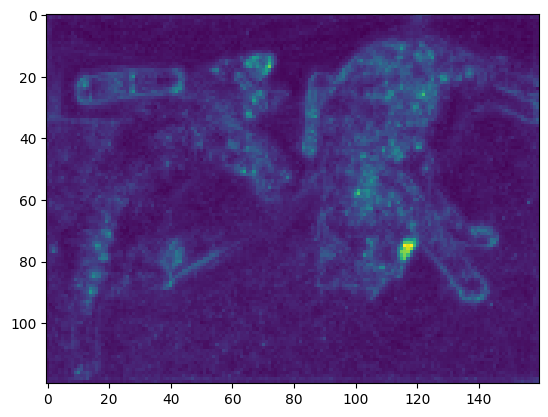

In [31]:
plt.imshow(normalize_map(np.mean(features_map, axis=0)), cmap="viridis")

In [112]:
from ultralytics import YOLO

model = YOLO('yolo11n.yaml')
model = model.model.model[:4]

outputs = model(inputs)

outputs.shape

torch.Size([1, 64, 60, 80])

In [98]:
avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

In [99]:
avgpool(outputs).shape

torch.Size([1, 64, 1, 1])

In [113]:
features_map = outputs.squeeze().detach().numpy()
features_map.shape

(64, 60, 80)

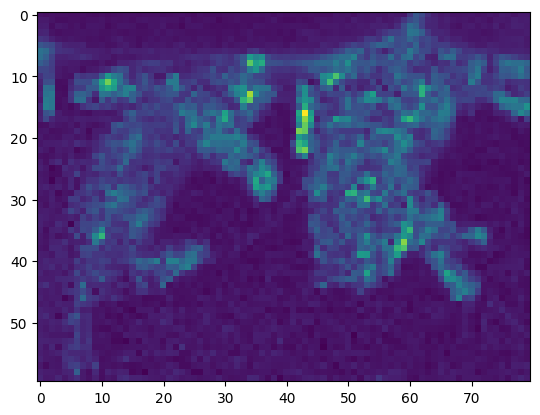

In [114]:
plt.imshow(normalize_map(np.mean(features_map, axis=0)), cmap="viridis")

In [83]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [95]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [96]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 